In [1]:
import sys 
sys.path.insert(0,'./src')
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from time import time
from multiprocessing import Pool

from dynamics_test import Dynamics as Dynamics_
from dynamics_test_ import Dynamics as Dynamics__
from dynamics_ import Dynamics as Dynamics
from economy import Economy
degree,n = 15,100

delta = 10**-3
u = np.random.uniform(-1,1)


In [2]:
def multi_get(input,func, processes= 5, array = True, tq = True):
    pool = Pool(processes = processes)
    try : 
        if tq : 
            output = pool.map(func,tqdm(input))
        else : 
            output = pool.map(func,input)
        pool.close()
    except KeyboardInterrupt or Exception : 
        pool.terminate()
        raise 
    finally : 
        pool.join()
    if array : return np.array(output)
    else : return output

In [21]:
eco_initial_conditions = {
    
    "n": n,
    "d":degree,
    "netstring":"regular",
    "directed":True,
    "j0":np.ones(n),
    "a0":np.ones(n)*0.5,
    "q":0.1,
    "b":0.95
    
}

house_initial_conditions = {
     "l_0":1, # Propension à travailler
     "theta":(np.ones(n)/n).copy(),
     "gamma":1,
     "phi":1,
     "omega_p":0.1,
     "f":None,
     "r":None

 }

firm_initial_conditons = {
    "z":np.ones(n), 
    "sigma":np.ones(n)*0.3,
    "alpha":0.5,
    "alpha_p":0.5,
    "beta":0.5,
    "beta_p":0.5,
    "omega":0.1
}


eps = 100
def init_d(d,house_initial_conditions,firm_initial_conditons,eps):
    np.random.seed(1)
    d.eco.clear_all()
    d.eco.init_house(**house_initial_conditions)
    d.eco.init_firms(**firm_initial_conditons)
    d.eco.set_quantities() # Help for equilibrium quantities. 
    d.eco.set_eps_cal(eps) # Changes z to have the samellest eigen value of M equals to eps.
    d.eco.compute_eq() 
    initial_conditions = {
    "p0":d.eco.p_eq*(1+delta*np.random.uniform(-1,1)),    # Prices [0.1,1]
    "w0":1,               # Wage at 1 
    "g0":d.eco.g_eq, # Prod [0.001,0.01]
    "t1":d.eco.g_eq, # Target [0.001,0.01]
    "s0":np.zeros((n,n)), # Stock 0
    "B0":0,               # Savings 0
    }
    d.set_initial_conditions(**initial_conditions)
    return d

degree,n = 15,100
e = Economy(**eco_initial_conditions)
d = Dynamics(e,100)
d = init_d(d,house_initial_conditions,firm_initial_conditons,eps)
d.discrete_dynamics()

In [10]:
# eco_initial_conditions = {
    
#     "n": n,
#     "d":degree,
#     "netstring":"regular",
#     "directed":True,
#     "j0":100*np.ones(n),
#     "a0":np.ones(n)*0.5,
#     "q":0,
#     "b":0.95
    
# }

# house_initial_conditions = {
#      "l_0":100, # Propension à travailler
#      "theta":(np.ones(n)/n).copy(),
#      "gamma":1,
#      "phi":1,
#      "omega_p":None,
#      "f":None,
#      "r":None

#  }

# firm_initial_conditons = {
#     "z":np.ones(n), 
#     "sigma":np.ones(n)*0.3,
#     "alpha":0.5,
#     "alpha_p":0.5,
#     "beta":0.5,
#     "beta_p":0.5,
#     "omega":0.1
# }

# initial_conditions = {
#     "p0":1*np.ones(n),    # Prices [0.1,1]
#     "w0":1,               # Wage at 1 
#     "g0":1*np.random.uniform(0.001,0.01,size = n), # Prod [0.001,0.01]
#     "t1":1*np.random.uniform(0.001,0.01,size = n), # Target [0.001,0.01]
#     "s0":np.zeros((n,n)), # Stock 0
#     "B0":0,               # Savings 0
# }

# eps = 100
# def init_d(d,house_initial_conditions,firm_initial_conditons,eps):
#     np.random.seed(0)
#     d.eco.clear_all()
#     d.eco.init_house(**house_initial_conditions)
#     d.eco.init_firms(**firm_initial_conditons)
#     d.eco.set_quantities() # Help for equilibrium quantities. 
#     d.eco.set_eps_cal(eps) # Changes z to have the samellest eigen value of M equals to eps.
#     d.eco.compute_eq() 
#     initial_conditions = {
#     "p0":1*np.ones(n),    # Prices [0.1,1]
#     "w0":1,               # Wage at 1 
#     "g0":1*np.random.uniform(0.001,0.01,size = n), # Prod [0.001,0.01]
#     "t1":1*np.random.uniform(0.001,0.01,size = n), # Target [0.001,0.01]
#     "s0":np.zeros((n,n)), # Stock 0
#     "B0":0,               # Savings 0
#     }    
#     d.set_initial_conditions(**initial_conditions)
#     return d

# degree,n = 15,100
# e = Economy(**eco_initial_conditions)
# d = Dynamics(e,100)
# d = init_d(d,house_initial_conditions,firm_initial_conditons,eps)
# d.discrete_dynamics()

In [11]:
def display_results(d,min_loss,axs = None ):
    
#     try : del e,d_
#     except : print("No delete")
#     e = Economy(**eco_initial_conditions)
    d_ = Dynamics_(e,100)
    d_ = init_d(d_,house_initial_conditions,firm_initial_conditons,eps)
    d_.update_min_loss(min_loss)
    try :
        d_.discrete_dynamics()
    except Exception as ex : 
        print(ex)
        return d_
    arg_n_max = np.argmax(d_.n_bkrpt)
    d_.n_bkrpt[arg_n_max:] = d_.n_bkrpt[arg_n_max]
    
    if axs is None : 
        fig,axs = plt.subplots(nrows = 1, ncols = 4, figsize=(10,5),dpi = 150, sharex = False)
        
    axs[0].plot(d.prices[1:].mean(axis = -1),label = "Theo")
    axs[0].plot(d_.prices[1:].mean(axis = -1),label = "Swann")
    axs[0].set_ylabel(r"$\bar{p}$")
    axs[0].set_title(f"Max loss {min_loss}")
    axs[0].set_xlabel(r"$t$")

    axs[1].plot(d.prods[1:].mean(axis = -1),label = "Theo")
    axs[1].plot(d_.prods[1:].mean(axis = -1),label = "Swann")
    axs[1].set_title(fr"$eps$ = {round(d_.eco.get_eps_cal(),3)}")
    axs[1].set_ylabel(r"$\bar{y}$")
    axs[1].set_xlabel(r"$t$")
    
    axs[2].matshow(d_.eco.j)
#     axs[2].set_title("Production network")
    
    axs[3].matshow(1-d_.contagion_matrix)
#     axs[3].set_title("Contagion matrix")

    ax2 = axs[0].twinx()
    ax2.plot(d_.n_bkrpt,color = "black", alpha = 0.5,linestyle = "dashed",label = "Theo")
    ax2 = axs[1].twinx()
    ax2.plot(d_.n_bkrpt,color = "black", alpha = 0.5,linestyle = "dashed",label = "Swann")
    ax2.set_ylabel("n_bkrpt")
    
    axs[0].legend(loc = "upper left")
    axs[1].legend(loc = "upper left")
    if axs is None : 
        plt.tight_layout()
#     print(f"Min loss = {min_loss}, eps = {round(d_.eco.get_eps_cal(),3)} ")
    return d_

In [12]:
main_folder = "'C:\\Users\\swann\\OneDrive\\Bureau\\Thèse\\"

In [13]:
np.array([1.]).astype(int)

array([1])

5it [00:03,  1.48it/s]


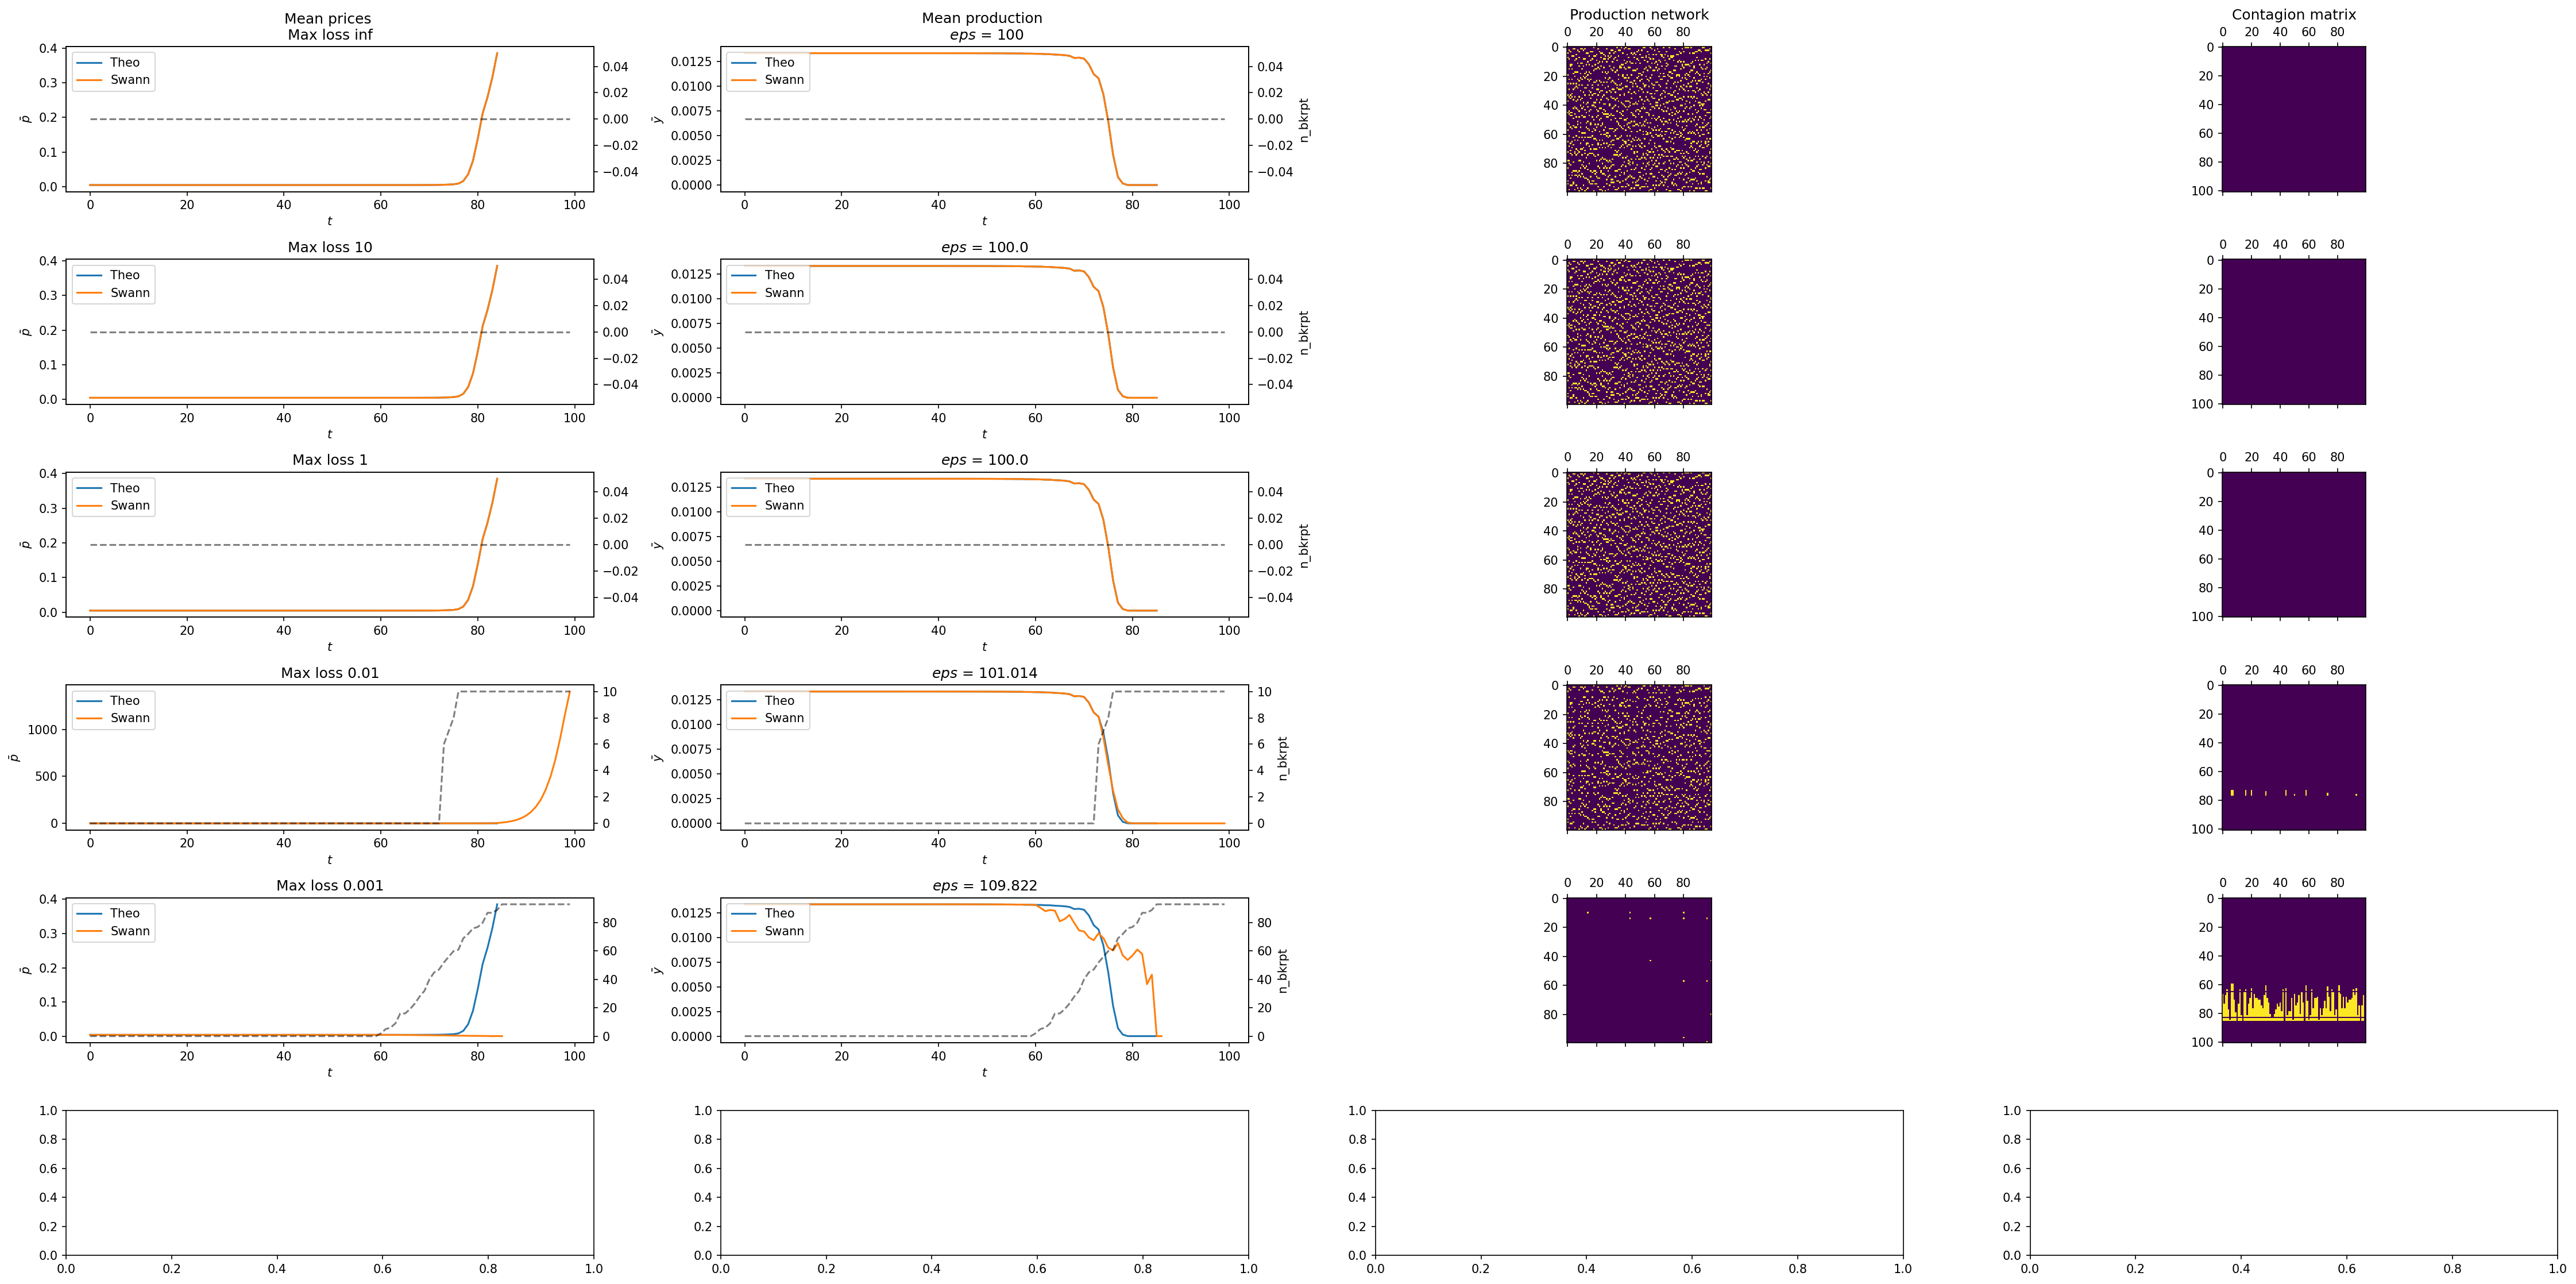

In [22]:
fig, axs = plt.subplots(nrows = 6, ncols = 4, figsize=(30,15),dpi = 150, sharex = False)    
for i,min_loss in tqdm(enumerate([np.inf,10,1,0.01,0.001])):
    d_ = display_results(d,min_loss,axs[i,:])
axs[0,0].set_title(f"Mean prices \n Max loss inf ")
axs[0,1].set_title(f"Mean production \n $eps$ = {round(100,3)}")
axs[0,2].set_title("Production network")
axs[0,3].set_title("Contagion matrix")
plt.tight_layout()
# fig.savefig("bkrpt.pdf")

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


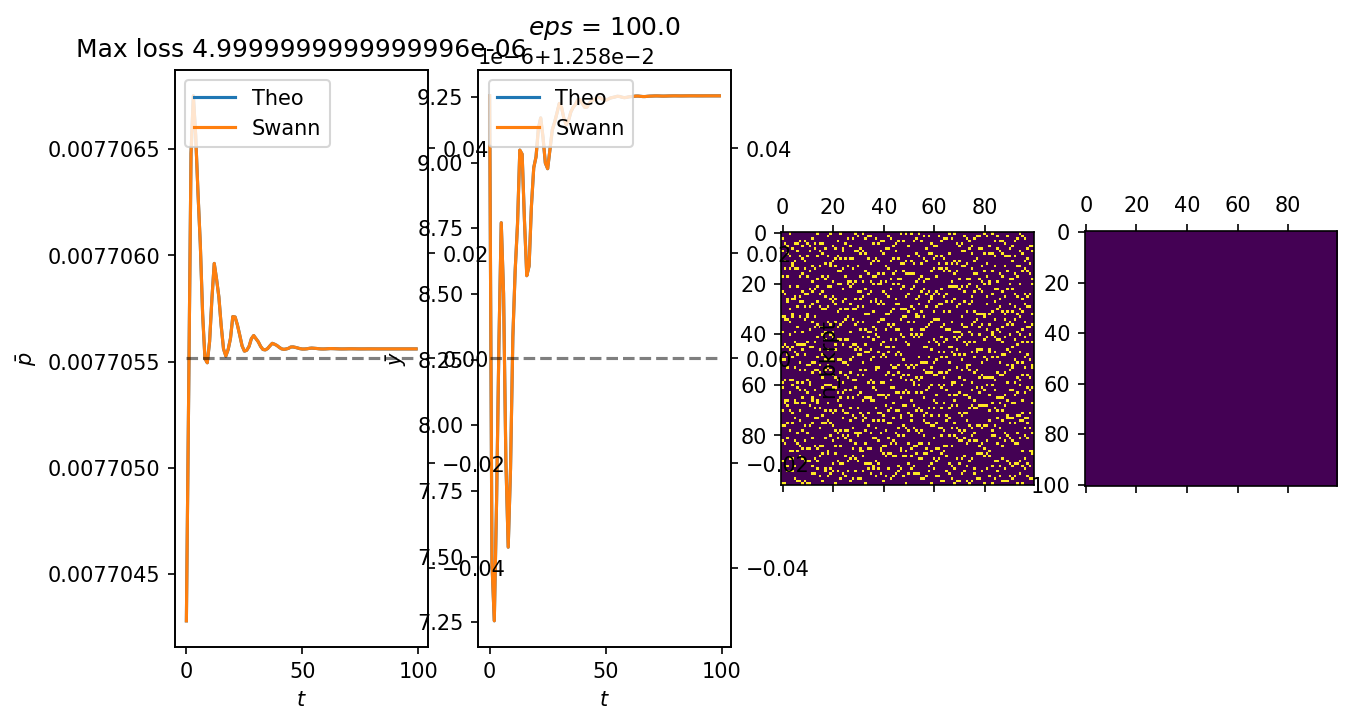

In [14]:
d_ = display_results(d,5*10**-6)

In [ ]:
d_

In [6]:
d_ = Dynamics_(e,100)
d_ = init_d(d_,house_initial_conditions,firm_initial_conditons,eps)
d_.update_min_loss(10)
d_.discrete_dynamics()

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
from tqdm import tqdm
from functools import partial

In [ ]:
e = Economy(**eco_initial_conditions)
d_ = Dynamics_(e,100)

In [ ]:
def eps_cal(d_,min_loss):
    
#     try : del e,d_
#     except : print("No delete")
#     e = Economy(**eco_initial_conditions)
    d_ = Dynamics_(e,100)
    
    d_ = init_d(d_,house_initial_conditions,firm_initial_conditons,eps,initial_conditions)
    
    d_.update_min_loss(min_loss)
    try :
        d_.discrete_dynamics()
    except : 
        pass
    return d_.eco.get_eps_cal()

min_losses = np.logspace(-5,3,num = 100)
eps_array = np.array([eps_cal(d_,min_loss) for min_loss in tqdm(min_losses)])

In [ ]:
# def eps_cal(min_loss):
    
# #     try : del e,d_
# #     except : print("No delete")
#     e = Economy(**eco_initial_conditions)
#     d_ = Dynamics_(e,100)
    
#     d_ = init_d(d_,house_initial_conditions,firm_initial_conditons,eps,initial_conditions)
    
#     d_.update_min_loss(min_loss)
#     try :
#         d_.discrete_dynamics()
#     except : 
#         pass
#     return d_.eco.get_eps_cal()

# min_losses = np.logspace(-5,3,num = 100)
# eps_array = multi_get(min_losses,partial(eps_cal))

In [ ]:
plt.semilogx(min_losses,eps_array)
plt.xlabel("Minimum loss")
plt.ylabel(r"$\epsilon$")
plt.title(r"Final $\epsilon$ of the production network according to bankruptcy threshold");

In [ ]:
(d_.gains-d_.losses).cumsum(axis = 0)[:,0]

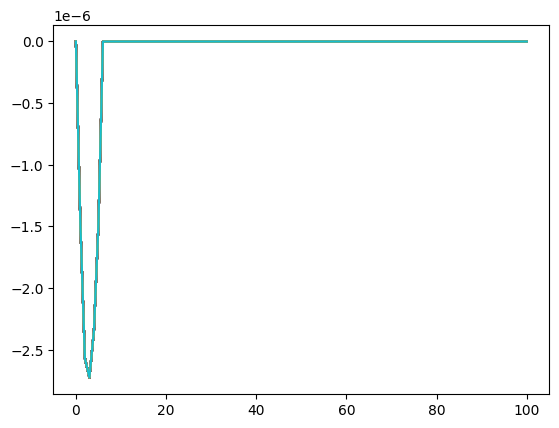

In [15]:
plt.plot((d_.gains-d_.losses).cumsum(axis = 0))